In [3]:
###
# The goal of this notebook is to:
# - Take two neural populations
# - Compute the JS divergence between stimuli pairs for each population (the same stimuli pairs)
# - Compute the mutual information between the distributions of JS divergences

import glob
import os
from importlib import reload
import pickle
import datetime

import numpy as np
import scipy as sp
import pandas as pd
import h5py as h5
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import neuraltda.topology2 as tp2
import neuraltda.spectralAnalysis as sa
import neuraltda.simpComp as sc
import pycuslsa as pyslsa

daystr = datetime.datetime.now().strftime('%Y%m%d')
figsavepth = '/home/brad/DailyLog/'+daystr+'/'
print(figsavepth)

/home/brad/DailyLog/20180607/


In [8]:
# Set up birds and block_paths
birds = ['B1083', 'B1056', 'B1235', 'B1075']
bps = {'B1083': '/home/brad/krista/B1083/P03S03/', 'B1075': '/home/brad/krista/B1075/P01S03/',
       'B1235': '/home/brad/krista/B1235/P02S01/', 'B1056': '/home/brad/krista/B1056/klusta/phy020516/Pen01_Lft_AP100_ML1300__Site03_Z2500__B1056_cat_P01_S03_1/',
       'B1056': '/home/brad/krista/B1056/klusta/phy020516/Pen01_Lft_AP100_ML1300__Site03_Z2500__B1056_cat_P01_S03_1/'}

bps =  {'B1056': '/home/AD/btheilma/krista/B1056/klusta/phy020516/Pen01_Lft_AP100_ML1300__Site03_Z2500__B1056_cat_P01_S03_1/'}
test_birds = ['B1075', 'B1083','B1056', 'B1235']
test_birds = ['B1056', 'B1235']
test_birds = ['B1056']
# Binning Parameters
windt = 10.0                      # milliseconds
dtovr = 0.5*windt                 # milliseconds
segment_info = [0, 0]             # use full Trial
cluster_group = ['Good']          # use just good clusters
comment = 'JS_MI_TEST'            # BootStrap Populations
bdfs = {}                         # Dictionary to store bdf

In [9]:
# Loop through each bird in our list and bin the data
for bird in test_birds:
    block_path = bps[bird]
    bfdict = tp2.dag_bin(block_path, windt, segment_info, cluster_group=cluster_group, dt_overlap=dtovr, comment=comment)
    bdf = glob.glob(os.path.join(bfdict['raw'], '*.binned'))[0]
    print(bdf)
    bdfs[bird] = bdf

/home/AD/btheilma/krista/B1056/klusta/phy020516/Pen01_Lft_AP100_ML1300__Site03_Z2500__B1056_cat_P01_S03_1/binned_data/win-10.0_dtovr-5.0_seg-0-0-JS_MI_TEST/20180525T180834Z-10.0-5.0.binned


In [3]:
bdfs={'B1083':'/home/brad/krista/B1083/P03S03/binned_data/win-10.0_dtovr-5.0_seg-0-0-JS_MI_TEST/20180525T180824Z-10.0-5.0.binned',
'B1056':'/home/brad/krista/B1056/klusta/phy020516/Pen01_Lft_AP100_ML1300__Site03_Z2500__B1056_cat_P01_S03_1/binned_data/win-10.0_dtovr-5.0_seg-0-0-JS_MI_TEST/20180525T180834Z-10.0-5.0.binned',
'B1235':'/home/brad/krista/B1235/P02S01/binned_data/win-10.0_dtovr-5.0_seg-0-0-JS_MI_TEST/20180525T180847Z-10.0-5.0.binned',
'B1075':'/home/brad/krista/B1075/P01S03/binned_data/win-10.0_dtovr-5.0_seg-0-0-JS_MI_TEST/20180525T180856Z-10.0-5.0.binned'}


In [4]:
test_birds = ['B1075', 'B1083','B1056', 'B1235']
test_birds = ['B1056', 'B1235']
test_birds = ['B1056']

In [10]:
# extract population tensors for the populations of interest
population_tensors = {}

for bird in test_birds:
    bdf = bdfs[bird]
    population_tensors[bird] = []
    # open the binned data file
    with h5.File(bdf, 'r') as f:
        stimuli = f.keys()
        print(list(stimuli))
        for stim in sorted(stimuli):
            poptens = np.array(f[stim]['pop_tens'])
            population_tensors[bird].append([poptens, stim])

['A_scaled_burung', 'B_scaled_burung', 'C_scaled_burung', 'D_scaled_burung', 'E_scaled_burung', 'F_scaled_burung', 'G_scaled_burung', 'H_scaled_burung', 'I_scaled_burung', 'J_scaled_burung', 'K_scaled_burung', 'L_scaled_burung', 'M_scaled_burung', 'N_scaled_burung', 'O_scaled_burung', 'P_scaled_burung']


In [11]:
# flatten the list of population tensors for each population
threshold = 6

def threshold_poptens(tens, thresh):
    ncell, nwins, ntrials = tens.shape
    frs = np.mean(tens, axis=1)
    tfr = thresh*frs
    tfrtens = np.tile(tfr[:, np.newaxis, :], (1, nwins, 1))
    bintens = 1*np.greater(tens, tfrtens)
    return bintens

def shuffle_binmat(binmat):
    ncells, nwin = binmat.shape
    for i in range(ncells):
        binmat[i, :] = np.random.permutation(binmat[i, :])
    return binmat

In [ ]:
popA_binmats = []
popB_binmats = []
popA_SCGs = []
popB_SCGs = []
binmats = [popA_binmats, popB_binmats]
binmats = [[], [], [], []]
SCGs = [[], [], [], []]
for SCG, binmatlist, bird in zip(SCGs, binmats, test_birds):
    bird_tensors = population_tensors[bird]
    for bird_tensor, stim in bird_tensors:
        ncells, nwin, ntrials = bird_tensor.shape
        bin_tensor = threshold_poptens(bird_tensor, threshold)
        for trial in tqdm(range(ntrials)):
            binmatlist.append(bin_tensor[:, :, trial])
            ms = sc.binarytomaxsimplex(bin_tensor[:, :, trial], rDup=True)
            SCG.append(pyslsa.build_SCG(ms))

In [12]:
SCGs = []
for bird in test_birds:
    SCG = []
    binmatlist = []
    bird_tensors = population_tensors[bird]
    for bird_tensor, stim in bird_tensors:
        ncells, nwin, ntrials = bird_tensor.shape
        bin_tensor = threshold_poptens(bird_tensor, threshold)
        for trial in tqdm(range(ntrials)):
            binmatlist.append(bin_tensor[:, :, trial])
            ms = sc.binarytomaxsimplex(bin_tensor[:, :, trial], rDup=True)
            SCG.append(pyslsa.build_SCG(ms))
    SCGs.append(SCG)

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

In [ ]:
# Compute Shuffled complexes
popA_binmats = []
popB_binmats = []
popA_SCGs = []
popB_SCGs = []
binmats = [popA_binmats, popB_binmats]
SCGs = [popA_SCGs, popB_SCGs]
for SCG, binmatlist, bird in zip(SCGs, binmats, test_birds):
    bird_tensors = population_tensors[bird]
    for bird_tensor, stim in bird_tensors:
        ncells, nwin, ntrials = bird_tensor.shape
        bin_tensor = threshold_poptens(bird_tensor, threshold)
        for trial in tqdm(range(ntrials)):
            mat = shuffle_binmat(bin_tensor[:, :, trial])
            binmatlist.append(mat)
            ms = sc.binarytomaxsimplex(mat, rDup=True)
            SCG.append(pyslsa.build_SCG(ms))

In [ ]:
# Compute JS popA:

dim = 1
beta = -1.0


for pop, pop_bird in zip(SCGs, test_birds):
    N = len(pop)
    jsmat = np.zeros((N,N))
    for i in tqdm(range(N)):
        for j in tqdm(range(i, N)):
            jsmat[i, j] = pyslsa.cuJS(pop[i], pop[j], dim, beta)
    with open('/home/brad/tmpdata/JSpop_batched{}.pkl'.format(pop_bird), 'wb') as f:
        pickle.dump(jsmat, f)



In [ ]:
import pickle
with open('/home/brad/tmpdata/JSpopA_dim3.pkl', 'wb') as f:
    pickle.dump(jsmat, f)

In [ ]:
# Compute JS popA:
from joblib import Parallel, delayed
dim = 1
beta = -1.0

for pop in SCGs:
    N = len(pop)
    jsmat = np.zeros((N,N))
    for i in tqdm(range(N)):
        row = Parallel(n_jobs=4)(delayed(pyslsa.cuJS)(pop[i], pop[j], dim, beta) for j in range(i, N))
        jsmat[i, :] = row

In [ ]:
from importlib import reload
reload(pyslsa)

In [ ]:
test_scgs = SCG[0:320]
%time testout = pyslsa.get_laplacian_spectra(test_scgs, 1)

In [ ]:
nscg = len(SCG)
test_scgs = SCG
pairs = []
for i in range(nscg):
    for j in range(i, nscg):
        pairs.append([test_scgs[i], test_scgs[j]])
        
# slice up pairs list into chunks of 40 and compute 
chunksize = 320
chunk_res = []
for i in tqdm(range(int(len(pairs)/chunksize))):
    to_comp = pairs[chunksize*i:chunksize*i+chunksize]
    res = pyslsa.cuJS_pairs(to_comp, 1, -1.0)
    chunk_res.append(res)

HBox(children=(IntProgress(value=0, max=160), HTML(value='')))

In [29]:
to_comp

[[<pyslsa.SCG at 0x7f5faae2fe40>, <pyslsa.SCG at 0x7f5fa53dbe40>],
 [<pyslsa.SCG at 0x7f5faae2fe40>, <pyslsa.SCG at 0x7f5fa5281030>],
 [<pyslsa.SCG at 0x7f5faae2fe40>, <pyslsa.SCG at 0x7f5fa52811c0>],
 [<pyslsa.SCG at 0x7f5faae2fe40>, <pyslsa.SCG at 0x7f5fa5281350>],
 [<pyslsa.SCG at 0x7f5faae2fe40>, <pyslsa.SCG at 0x7f5fa52814e0>],
 [<pyslsa.SCG at 0x7f5faae2fe40>, <pyslsa.SCG at 0x7f5fa5281670>],
 [<pyslsa.SCG at 0x7f5faae2fe40>, <pyslsa.SCG at 0x7f5fa5281800>],
 [<pyslsa.SCG at 0x7f5faae2fe40>, <pyslsa.SCG at 0x7f5fa5281990>],
 [<pyslsa.SCG at 0x7f5faae2fe40>, <pyslsa.SCG at 0x7f5fa5281b20>],
 [<pyslsa.SCG at 0x7f5faae2fe40>, <pyslsa.SCG at 0x7f5fa5281cb0>],
 [<pyslsa.SCG at 0x7f5faae2fe40>, <pyslsa.SCG at 0x7f5fa5281e40>],
 [<pyslsa.SCG at 0x7f5faae2fe40>, <pyslsa.SCG at 0x7f5fa528d030>],
 [<pyslsa.SCG at 0x7f5faae2fe40>, <pyslsa.SCG at 0x7f5fa528d1c0>],
 [<pyslsa.SCG at 0x7f5faae2fe40>, <pyslsa.SCG at 0x7f5fa528d350>],
 [<pyslsa.SCG at 0x7f5faae2fe40>, <pyslsa.SCG at 0x7f5fa528d4e

In [14]:
%time pyslsa.cuJS_pairs(pairs, 1, -1.0)

CPU times: user 2min 12s, sys: 18 s, total: 2min 30s
Wall time: 2min 28s


[0.0,
 0.3203171823088693,
 0.4975066467442908,
 0.6469581009001801,
 0.4676033951656848,
 0.3114413729141839,
 0.8285801137406701,
 0.22739495073690463,
 0.4493110335850945,
 0.4577285282947547,
 0.3778302278356956,
 0.24042648171947975,
 0.28126555421525773,
 0.23668534147351827,
 0.17380697198739545,
 0.25998473911949044,
 0.6177966183799293,
 0.22639906933149084,
 0.3021279158012055,
 0.2672511352380731,
 0.262834823850488,
 0.19261854615631951,
 0.23015581884152025,
 0.19211713929152602,
 0.26932084292621383,
 0.2518955191698919,
 0.1776732267380694,
 0.1868747917363083,
 0.3805501968041445,
 0.17911434909666768,
 0.15946426369862746,
 0.2626830642308543,
 0.24929367589010704,
 0.2941345027438539,
 0.3844521765587245,
 0.19438678325255726,
 0.17320708069419816,
 0.2557105111925819,
 0.31711885698014824,
 0.39645531542800544,
 0.0,
 0.3741622141362672,
 0.5656756810019964,
 0.3834659340398232,
 0.2270514636089784,
 0.7940848518573873,
 0.24125614845128945,
 0.3573941844469989,
 0.3

In [26]:
for i in range(int(len(pairs)/42)):
    print(pairs[42*i:42*i+42])

[[<pyslsa.SCG object at 0x7f5faae2fb20>, <pyslsa.SCG object at 0x7f5faae2fb20>], [<pyslsa.SCG object at 0x7f5faae2fb20>, <pyslsa.SCG object at 0x7f5faae2fe40>], [<pyslsa.SCG object at 0x7f5faae2fb20>, <pyslsa.SCG object at 0x7f5fa54ba030>], [<pyslsa.SCG object at 0x7f5faae2fb20>, <pyslsa.SCG object at 0x7f5fa54ba1c0>], [<pyslsa.SCG object at 0x7f5faae2fb20>, <pyslsa.SCG object at 0x7f5fa54ba350>], [<pyslsa.SCG object at 0x7f5faae2fb20>, <pyslsa.SCG object at 0x7f5fa54ba4e0>], [<pyslsa.SCG object at 0x7f5faae2fb20>, <pyslsa.SCG object at 0x7f5fa54ba670>], [<pyslsa.SCG object at 0x7f5faae2fb20>, <pyslsa.SCG object at 0x7f5fa54ba800>], [<pyslsa.SCG object at 0x7f5faae2fb20>, <pyslsa.SCG object at 0x7f5fa54ba990>], [<pyslsa.SCG object at 0x7f5faae2fb20>, <pyslsa.SCG object at 0x7f5fa54bab20>], [<pyslsa.SCG object at 0x7f5faae2fb20>, <pyslsa.SCG object at 0x7f5fa54bacb0>], [<pyslsa.SCG object at 0x7f5faae2fb20>, <pyslsa.SCG object at 0x7f5fa54bae40>], [<pyslsa.SCG object at 0x7f5faae2fb20>,

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
%time testout = pyslsa.get_laplacian_spectra(test_scgs, 1)

In [15]:
testjs = _

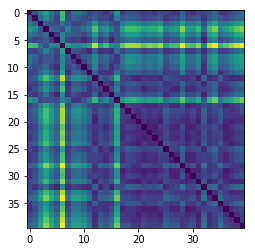

In [19]:
m = np.zeros((nscg, nscg))
inds = np.triu_indices(nscg)
m[inds] = testjs

plt.imshow(m+m.T)